In [1]:
#libraries
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parents[0]) 

In [15]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
from STOMPnet import STOMPnet
from utils import MultiChannelNet, get_width, count_parameters
from STOMPnet import Decoder
import h5py
import yaml
import json
import hashlib
import wandb

Pull a dataset to use to initialize a network

In [3]:
def get_runs():
    api = wandb.Api()
    runs = api.runs("STOMP")
    summary_list, config_list, name_list, state_list = [], [], [], []
    for run in runs:
        # .summary contains output keys/values for
        # metrics such as accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

        state_list.append(run.state)

    runs_df = pd.DataFrame(
        {"summary": summary_list, "config": config_list, "name": name_list, "state": state_list}
    )

    runs_df.to_csv("project.csv")
    runs_df.loc[:,['state','config']].apply(lambda run: run.state+
                                           ': N'+str(run.config['num_agents'])+
                                           ', P'+str(run.config['P'])+
                                           ' '+run.config['model_name'] if run.state=='finished' else run.state,axis=1)
    return runs_df
runs_df=get_runs()

In [4]:
train_config=runs_df.iloc[0].config
print(json.dumps(train_config,sort_keys=True, indent=4))
config_filename = train_config['outdir'] + train_config['data_dir'] + '/config.yaml'
with open(config_filename, 'r') as f:
    data_config = yaml.load(f, Loader=yaml.FullLoader)['file_attrs']
    print(json.dumps(data_config,sort_keys=True, indent=4))

{
    "L": 100,
    "M": 2,
    "P": 10000000.0,
    "action_space_dim": 2,
    "batch_size": 8,
    "checkpoint_interval": 100,
    "data_dir": "data_131101a005",
    "data_seed": 0,
    "enc2dec_ratio": 1,
    "epochs": 200,
    "learning_rate": 1e-05,
    "model_name": "stomp",
    "n_features": 2,
    "n_hidden_layers": 2,
    "num_action_samples": 1280,
    "num_agents": 10,
    "num_codebooks": 10,
    "num_parameters": 10005127,
    "outdir": "output/",
    "seed": 2,
    "state_space_dim": 3,
    "wandb_entity": null
}
{
    "A": 2,
    "K": 3,
    "M": 2,
    "N": 10,
    "T": 128,
    "action_selection_method": "greedy",
    "corr": 0.8,
    "ensemble": "mix",
    "env": false,
    "ground_model_name": "bitpop",
    "hash": "131101a005",
    "num_episodes": 1,
    "num_seeds": 10,
    "num_warmup_steps": 100,
    "output": "output/",
    "sps": 16,
    "stablefac": 8.0,
    "timestamp": "20240416_004000"
}


define function that initializes network

In [21]:
def get_untrained_net(training_dict,data_settings,hidden_dim,model_name):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device", flush=True)
    args=training_dict.copy()
    action_space_dim = 2
    state_space_dim = data_settings['K']
    num_agents = int(data_settings['N'])
    # Initialize abstraction system model
    n_hidden_layers = args["n_hidden_layers"]
    if model_name == 'stomp':
        # to match the M generated by joint policy of ground model set as: data_settings['sys_parameters']['jointagent_groundmodel_paras']['M']
        net = STOMPnet(
            state_space_dim = state_space_dim,
            abs_action_space_dim = args["L"],
            enc_hidden_dim = hidden_dim,
            dec_hidden_dim = int(args["enc2dec_ratio"]*hidden_dim),
            num_agents=num_agents,
            num_abs_agents = args["M"],
            action_space_dim=action_space_dim,
            agent_embedding_dim= args["n_features"],
            n_hidden_layers=n_hidden_layers,
            num_codebooks=args["num_codebooks"]
        )
    elif model_name == 'single':
        net = MultiChannelNet(
            n_channels=num_agents,
            input_size=state_space_dim,
            hidden_layer_width= hidden_dim,
            n_hidden_layers=n_hidden_layers,
            output_size=action_space_dim
        )
    elif model_name == 'multi':
        net = MultiChannelNet(
            n_channels=1,
            input_size=state_space_dim,
            hidden_layer_width= hidden_dim,
            n_hidden_layers=n_hidden_layers,
            output_size=num_agents*action_space_dim,
            output_dim=(num_agents, action_space_dim)
        )
    elif model_name == 'decoderonly':
        #feeds state directly into decoder by overloading the assigned abstract action input
        net = Decoder(
            num_agents=num_agents, 
            abs_action_space_dim=state_space_dim, 
            action_space_dim=action_space_dim, 
            agent_embedding_dim=args["n_features"], 
            n_hidden_layers=n_hidden_layers, 
            hidden_layer_width=int(args["enc2dec_ratio"]*hidden_dim)
        )
    else:
        print('choose valid model', flush=True)
    net.to(device)
    return net
    

Validation

In [23]:
model_names = ['stomp', 'decoderonly','multi','single']

In [89]:
Nvec=[1e1,1e2,1e3,1e4]
Pvec= [1e6,1e7,1e8,1e9]
df=pd.DataFrame(columns=('model_name','P','N','width','Pactual'))
for mit,model_name in enumerate(model_names):
    train_config['model_name'] = model_name
    for num_paras in Pvec:
        train_config['P'] = num_paras
        Wvec=[]
        for N in Nvec:
            data_config['N']=N
            solver_dict = {"model_name": train_config['model_name'],
                "n_hidden_layers": train_config['n_hidden_layers'],
                "num_abs_agents": train_config['M'],
                "abs_action_space_dim": train_config['L'],
                "n_features": train_config['n_features'],
                "num_agents": data_config['N'],
                "state_space_dim": data_config['K'],
                "action_space_dim": data_config['A'],
                "enc2dec_ratio": train_config['enc2dec_ratio'],
                "num_parameters": train_config['P']
                 }
            hidden_dim = int(get_width(solver_dict))
            print(hidden_dim)
            Wvec.append(hidden_dim)        
#         data_settings['sys_parameters']['K']=10   
            net=get_untrained_net(train_config,data_config,hidden_dim,model_name)
            P_actual = count_parameters(net)
            df=df.append({
                            'model_name':model_name,
                            'P':np.log10(train_config['P']),
                            'N':N,
                            'width':hidden_dim,
                            'Pactual':P_actual
                        },ignore_index=True)

383
Using cpu device
383
Using cpu device
382
Using cpu device
375
Using cpu device
1265
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


1265
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


1265
Using cpu device
1262
Using cpu device
4056
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


4056
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


4056
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


4055
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


12884
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


12884
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


12884
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


12883
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


705
Using cpu device
705
Using cpu device
704
Using cpu device
698
Using cpu device
2234
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


2234
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


2234
Using cpu device
2232
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


7069
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


7069
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


7069
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


7068
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


22358
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


22358
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


22358
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


22358
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


701
Using cpu device
658
Using cpu device
365
Using cpu device
49
Using cpu device
2230
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


2185
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


1790
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


477
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


7065
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


7020
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


6588
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


3659
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


22354
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


22309
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


21865
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


17912
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


222
Using cpu device
69
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


21
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


5
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


705
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


222
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


69
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


21
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


2234
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


705
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


222
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


69
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


7069
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


2234
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


705
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


222
Using cpu device


/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({
/tmp/ipykernel_3317/3402676874.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({


In [13]:
import seaborn as sns

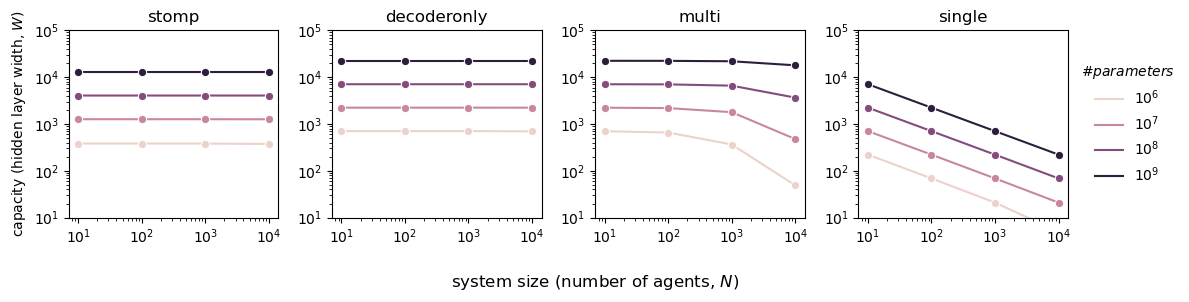

In [90]:
fig,ax=pl.subplots(1,len(model_names),figsize=(3*len(model_names),3))

for mit,model_name in enumerate(model_names):
    
#     ,label="{:.2e}".format(num_paras)
    sns.lineplot(data=df.loc[df['model_name']==model_name],
                    ax=ax[mit],
                    x='N',
                    y='width',
                    hue='P',
                    marker='o',
                    legend=False if mit<3 else True)
    if mit>0:
        ax[mit].set_ylabel(None)
    ax[mit].set_xlabel(None)
    ax[mit].set_yscale('log')
    ax[mit].set_xscale('log')
    ax[mit].set_ylim(1e1,1e5)
    ax[mit].set_title(model_name)
# ax[1].plot(np.logspace(1,4,10),10*np.logspace(1,4,10)[::-1]**(1/2))
ax[0].set_ylabel('capacity (hidden layer width, $W$)')
h, l = ax[3].get_legend_handles_labels()
ax[3].legend(h,[r"$10^"+string[0]+r"$" for string in l],frameon=False,title=r'$\# parameters$',loc='center left', bbox_to_anchor=(1, 0.5))  
fig.supxlabel(r'system size (number of agents, $N$)')
fig.tight_layout()

In [91]:
df['relative_error']=(10**df['P']-df['Pactual'])/df['Pactual']

<AxesSubplot: >

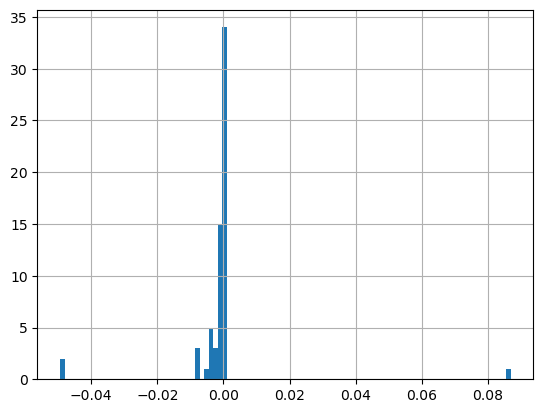

In [92]:
df["relative_error"].hist(bins=100)